In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

/home/wald/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Representing and drawing boards

The board is represented as 2*16 matrix. Each player has a row and the first 8 indices represent the front row, while the second half are the back rows flipped around. The direction of play is the same for both players, but as the field is not turned around we take the perspective of the second player. The first row goes left, the second row goes right.

In [2]:
#Matrix Representation
board =  np.full((2,16),2)
board

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [ ]:
def draw_board(ax, board):
    '''helper function for draw board
       draws a single board'''
    x = np.arange(16)
    one = ax.bar(x, board[0], color='b', edgecolor='black')
    two = ax.bar(x, -board[1], color='r', edgecolor='black')

    for bar in one:
        for i in range(1, int(bar.get_height())):
            ax.hlines(i, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)

    for bar in two:
        for i in range(1, int(abs(bar.get_height()))):
            ax.hlines(-i, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

def draw_boards(boards):
    '''draws several boards'''
    n_boards = len(boards)
    n_cols = 4
    n_rows = (n_boards + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    for i, board in enumerate(boards):
        draw_board(axs[i], board)

    # Hide any unused subplots
    for i in range(n_boards, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

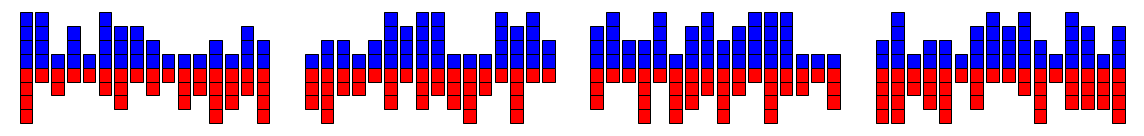

In [21]:
# Example usage:
# Each board is a 2x16 numpy array
boards = [np.random.randint(1, 5, (2, 16)) for _ in range(4)] 
draw_boards(boards)

### Legal moves

is_legal checks, if a field is a legal starting position. find_legal_moves returns an array with all legal start position for a specific player.

In [9]:
def is_legal(player, field, board):
    '''check if a field is a legal starting field'''
    if board[player, field] > 1 and (board[player,:8].sum() != 0) and (board[(player+1)%2,:8].sum() != 0): return True
    else: return False

In [ ]:
#example
is_legal(0,0,board)

True

In [11]:
def find_legal_moves(player,board):
    '''returns the legal moves for a player and a board'''
    legal_moves = []
    if (board[player,:8].sum() != 0) and (board[(player+1)%2,:8].sum() != 0):
        for i in range(16):
            if board[player, i] > 1:
                legal_moves.append(i)
    return legal_moves

In [ ]:
#example
find_legal_moves(0, board)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

### Move

A given legal move is calculated by first creating two matrices, where the first contains the number and position of stones to be taken and the second the number and position where they are to add. These are then used to calculate the next board.

In [13]:
def take_stones(player, field, board, steal = False):
    '''returns a subtraction matrix'''
    to_take = np.zeros((2,16), dtype=int)
    to_take[player, field] = board[player, field]
    if steal and field < 8:
        to_take[(player+1)%2,field] = board[(player+1)%2, field]
    return to_take

In [14]:
board =  np.full((2,16),2)
take_stones(0,0,board)

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
board =  np.full((2,16),2)
take_stones(0,0,board, True)

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
def add_stones(player, field, to_take):
    '''returns a addition matrix and then next field'''
    to_add = np.zeros((2,16),dtype=int)
    stones = to_take.sum()
    if player == 0:
        for i in range(1, stones+1):
            to_add[player,(field-i)%16] += 1
        return to_add, (field-i)%16
    if player == 1:
        for i in range(1,stones+1):
            to_add[player,(field+i)%16] += 1
        return to_add, (field+i)%16
       

In [17]:
to_take = take_stones(0,0,board, True)
add_stones(0,0,to_take)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 12)

In [18]:
def move(player, field, board, steal = False):
    '''return the actualized boad and the next start position'''
    if is_legal(player, field, board):
        to_take = take_stones(player, field, board, steal)
        to_add, next_field = add_stones(player, field, to_take)
        board = board - to_take  + to_add
        return board, next_field
    else: return "No legal move"

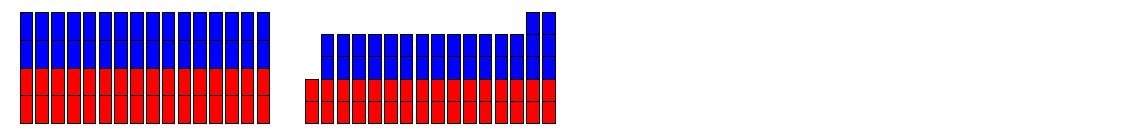

In [ ]:
#Example
board =  np.full((2,16),2)
board_first, _ = move(0,0,board)
draw_boards([board, board_first])

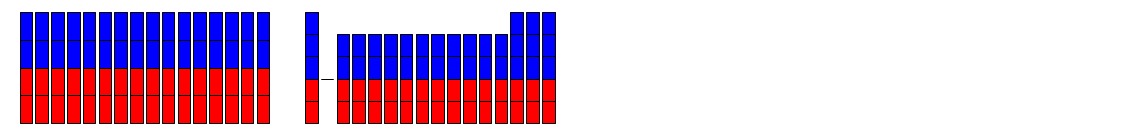

In [ ]:
#Example
board =  np.full((2,16),2)
board_first, _ = move(0,1,board, steal = True)
draw_boards([board, board_first])

### Turn

A full turn contains several moves. 

There is a counter because the game logic could lead to infinite loops.

In [32]:
def full_turn(player, field, board):
    '''wraps up everything to a full turn
    returns the resulting board'''
    steal = False
    counter = 0
    while is_legal(player, field, board):
        counter += 1
        board, field = move(player, field, board, steal)
        if not steal: steal = True
        if counter > 99:
            print("Eternal Loop!")
            return board
    return board

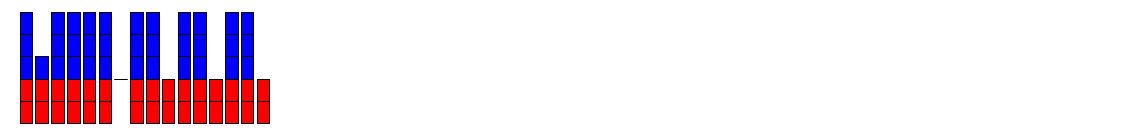

In [ ]:
#example
board =  np.full((2,16),2)
board = full_turn(0,1,board,)
draw_boards([board])

### Visualize full turn

The stones taken and replaced are now visualized as green boxes.

In [44]:
def save_full_turn(player, field, board):
    '''return all intermediate steps of a move, that is, all subtraction and addition matrices
    does not return the resulting board (can be calculated by full_turn()) and is also returned by the following drawing function'''
    boards_turn = []
    steal = False
    counter = 0
    while is_legal(player, field, board):
        counter += 1
        to_take = take_stones(player, field, board, steal)
        to_add, _ = add_stones(player, field, to_take)
        board, field = move(player, field, board, steal)
        boards_turn.append(to_take)
        boards_turn.append(to_add)
        if not steal: steal = True
        if counter > 99:
            print("Eternal Loop!")
            return
    return np.array(boards_turn)

In [47]:
#example
board = np.full((2,16),2)
turns = save_full_turn(0,0,board)
turns


array([[[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
def draw_turns(turns, board):
    '''takes the array of save_full_turn() and the starting positions and draws all steps
    returns the resulting board'''
    n_boards = len(turns)
    n_cols = 4
    n_rows = (n_boards + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2 * n_rows))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing
    x = np.arange(16)
    
    for i in range(0,len(turns),2):

        board = board - turns[i]
        
        one = axs[i].bar(x, board[0], color='b', edgecolor='black')
        one_add = axs[i].bar(x, turns[i][0], color = "g", edgecolor = "black")
        two = axs[i].bar(x, -board[1], color='r', edgecolor='black')
        two_add = axs[i].bar(x, -turns[i][1], color = "g", edgecolor = "black")
        
        for bar in one:
            for j in range(1, int(bar.get_height())):
                axs[i].hlines(j, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)

        for bar in two:
            for j in range(1, int(abs(bar.get_height()))):
                axs[i].hlines(-j, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)

        for bar in one_add:
            for j in range(1, int(bar.get_height())):
                axs[i].hlines(j, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)


        for bar in two_add:
            for j in range(1, int(abs(bar.get_height()))):
                axs[i].hlines(-j, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)

        
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        
        
        one = axs[i+1].bar(x, board[0], color='b', edgecolor='black')
        one_add = axs[i+1].bar(x, turns[i+1][0], bottom = board[0], color='g', edgecolor='black')
        two = axs[i+1].bar(x, -board[-1], color='r', edgecolor='black')
        two_add = axs[i+1].bar(x, -turns[i+1][1], bottom = -board[1], color='g', edgecolor='black')

      
        for bar in one:
            for j in range(1, int(bar.get_height())):
                axs[i+1].hlines(j, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)

        for bar in two:
            for j in range(1, int(abs(bar.get_height()))):
                axs[i+1].hlines(-j, bar.get_x(), bar.get_x() + bar.get_width(), color='black', linewidth=1)
        
        axs[i+1].spines['top'].set_visible(False)
        axs[i+1].spines['right'].set_visible(False)
        axs[i+1].spines['left'].set_visible(False)
        axs[i+1].spines['bottom'].set_visible(False)
        axs[i+1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        board = board + turns[i+1]
    
    # Hide any unused subplots
    for i in range(n_boards, len(axs)):
       axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    
    #return fig, axs
    return board


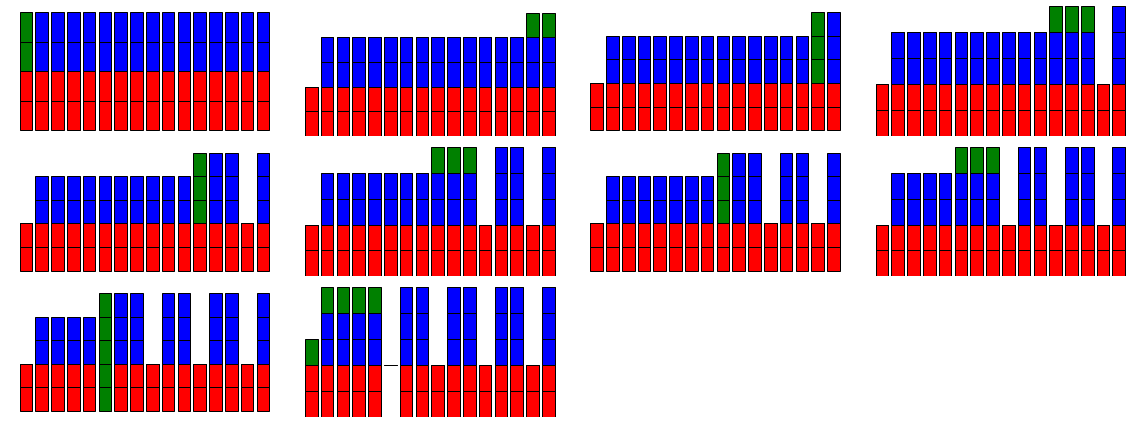

In [51]:
#starting from the beginning with player 0
new_board = draw_turns(turns, board)

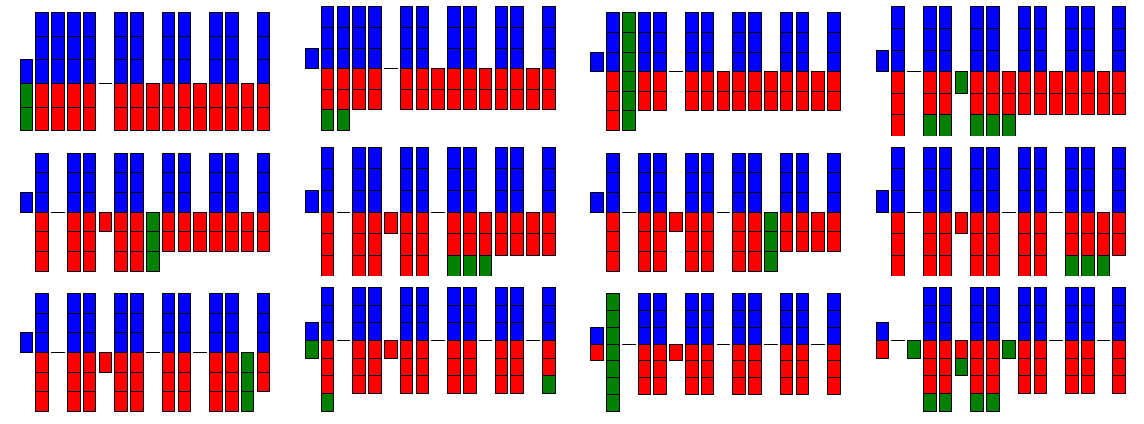

array([[1, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3],
       [1, 0, 1, 4, 4, 2, 4, 4, 1, 3, 3, 0, 3, 3, 0, 3]])

In [52]:
#next move
find_legal_moves(1,new_board)
turns = save_full_turn(1,0,new_board)
draw_turns (turns, new_board)

### A full game visualized

In [60]:
def visualize_game(board, moves, player):
    for i in range(len(moves)):
        turns = save_full_turn(player, moves[i], board)
        board = draw_turns(turns, board)
        player = (player+1)%2

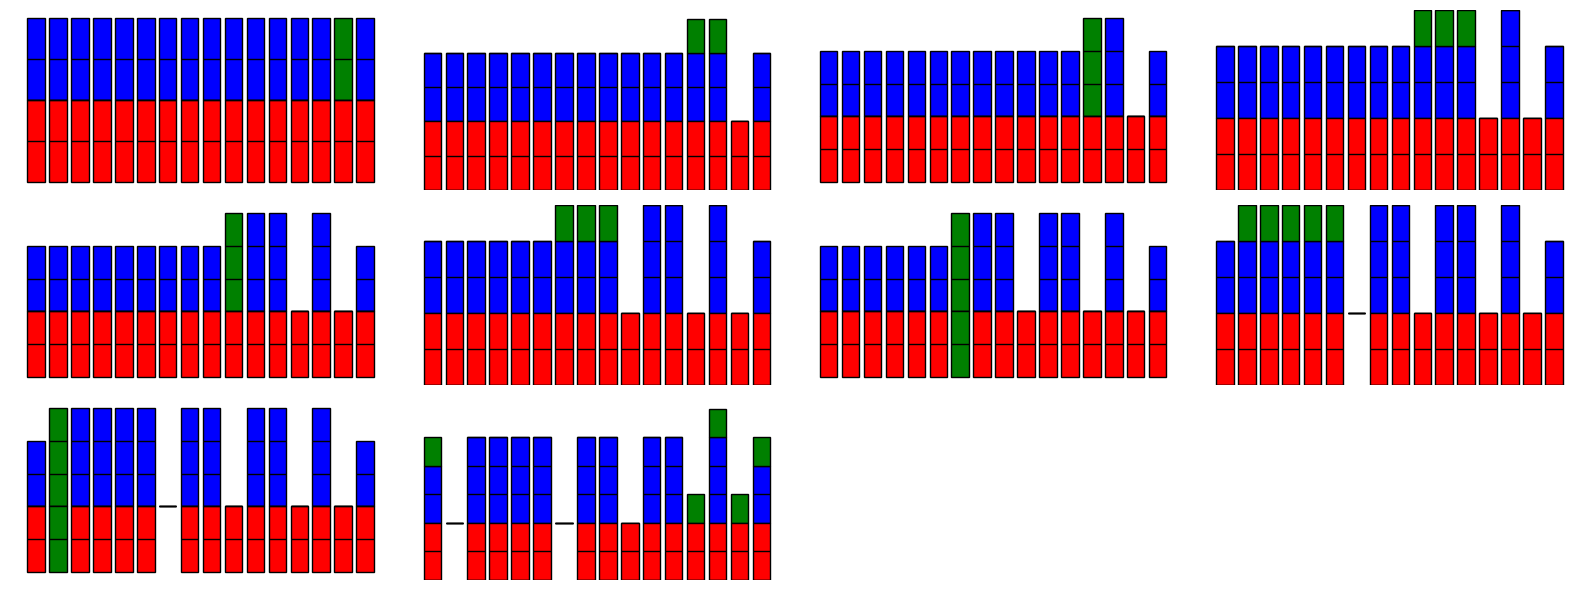

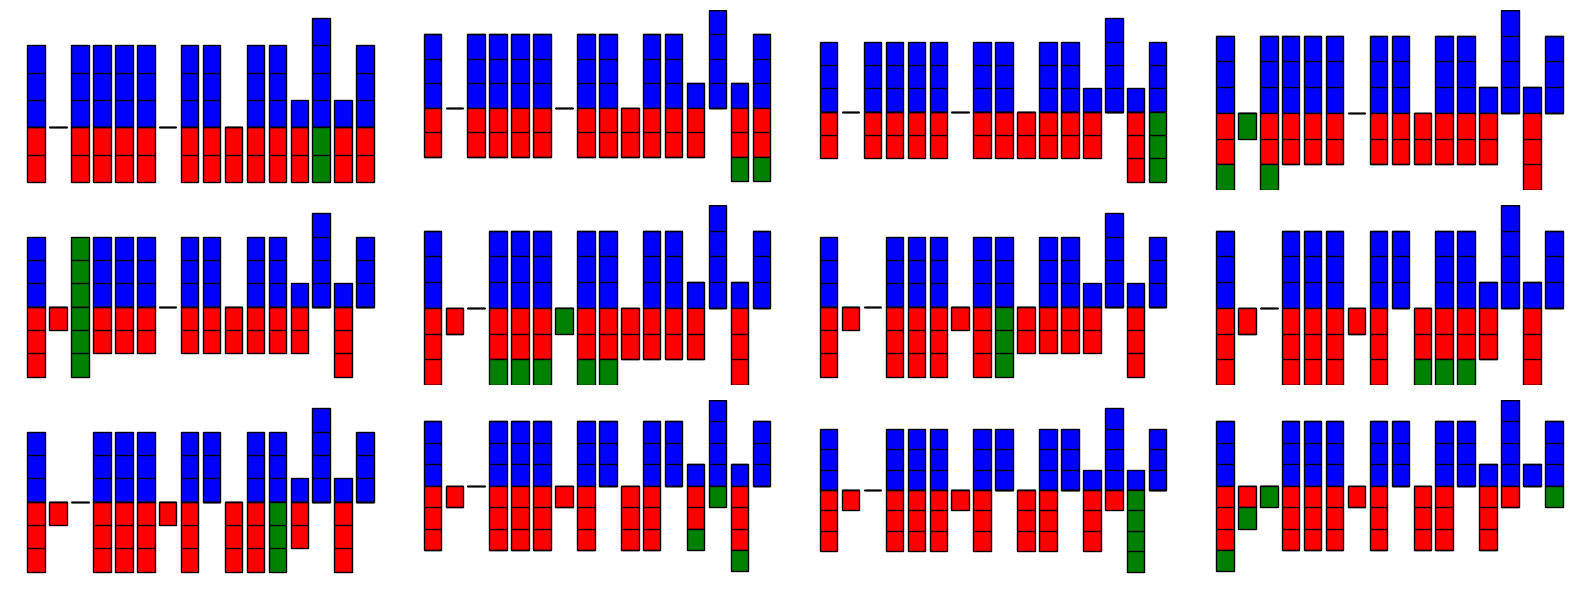

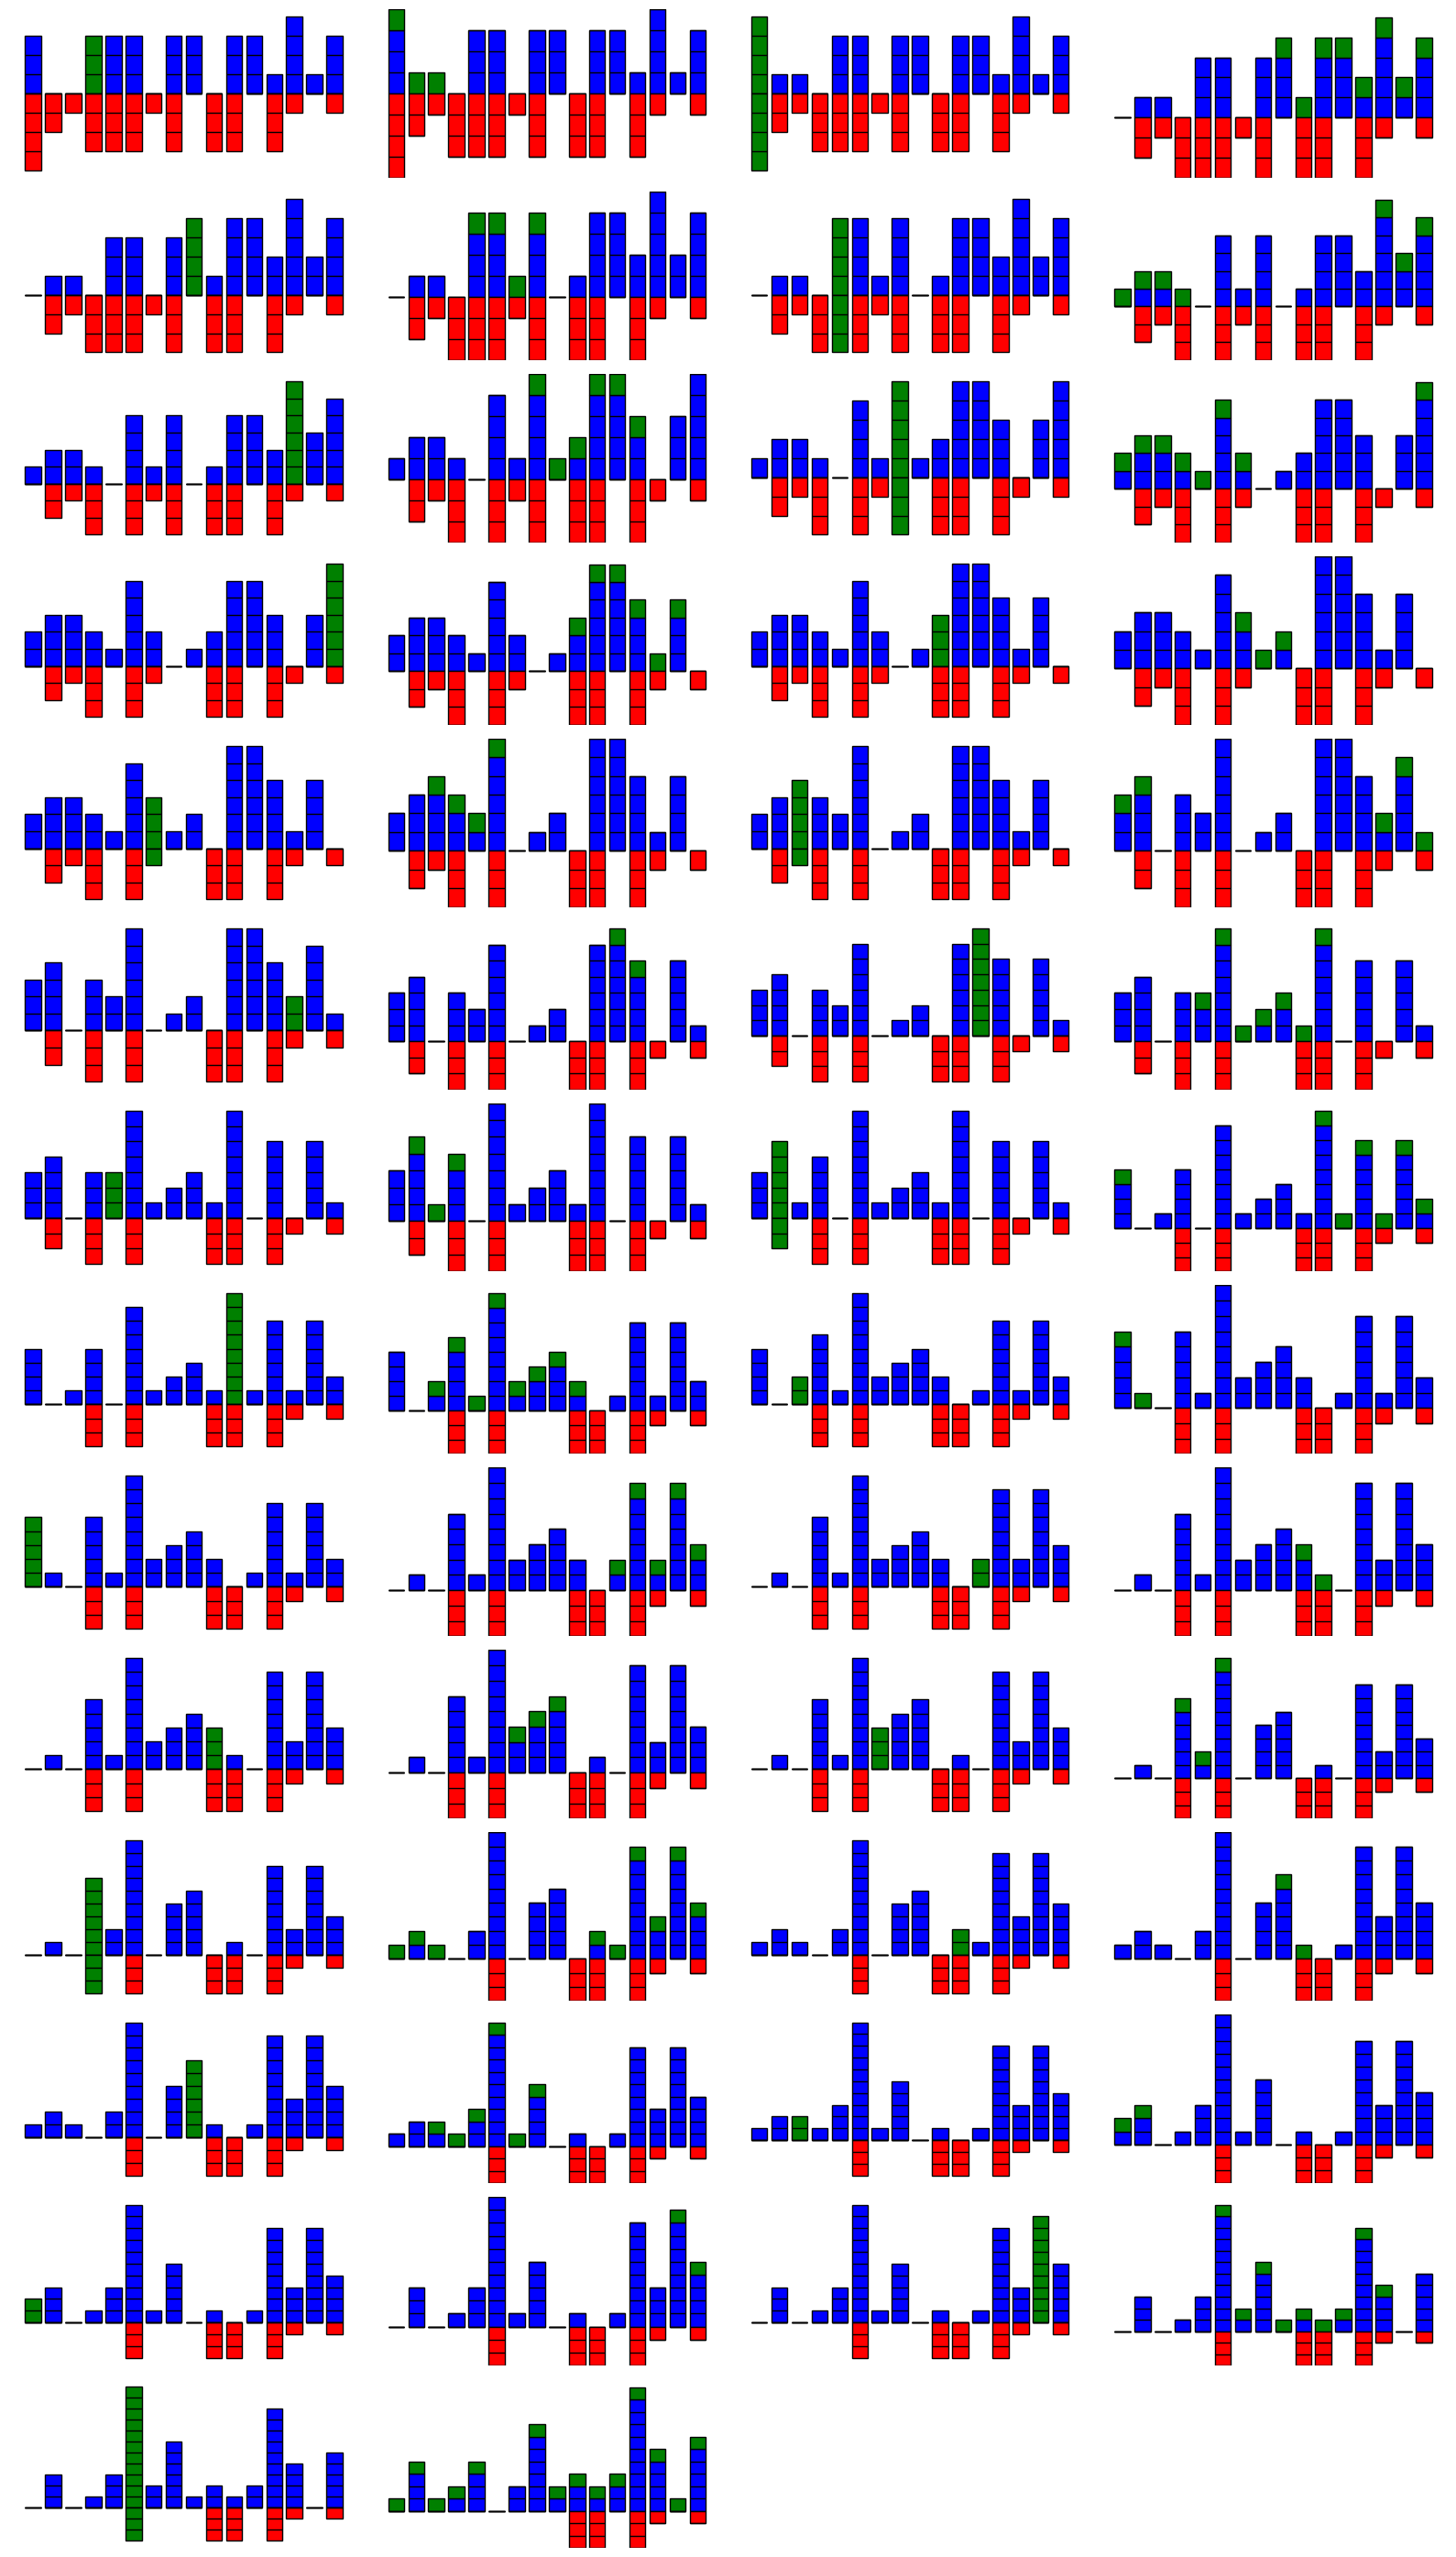

In [202]:
#the shortest game with only three turns
board = np.full((2,16),2)
moves = [14,13,3]
player = 0
visualize_game(board, moves, player)


### Play a game with random moves

For every move all legal moves are collected one is choosen randomly if more than one legal move is possible.

The function returns all positions after each moves, all used moves (as starting positions) and a ratio of moves, that needed random choosing.

In [ ]:
def play_game_random():
    ''' all board posititions (array), all starting positions (array) and a ratio (float)'''
    board =  np.full((2,16),2)
    game_positions = [] #collects the positions
    game_fields = [] #collects the start field of the game
    game_positions.append(board.copy()) #save the first position
    player = 0
    count = 0 #collects the number of moves in one turn
    chance = 0 #collects the number of moves in one turn that are choosen randomly from the possible moves
    legal_moves = find_legal_moves(player, board)
    while len(legal_moves) > 0:
        field = random.choice(legal_moves)
        if len(legal_moves) > 1: chance += 1
        game_fields.append(field) #save the start field
        board = full_turn(player, field, board)
        game_positions.append(board.copy()) #saves the new positions
        player = (player + 1)%2 #selects the other player
        legal_moves = find_legal_moves(player, board)
        count += 1
    return game_positions, game_fields, chance/count


In [54]:
positions, moves, randomness = play_game_random()
print(f"The game lasted {len(positions)} turns and was to {randomness*100}% guided by random choices.")

The game lasted 6 turns and was to 100.0% guided by random choices.


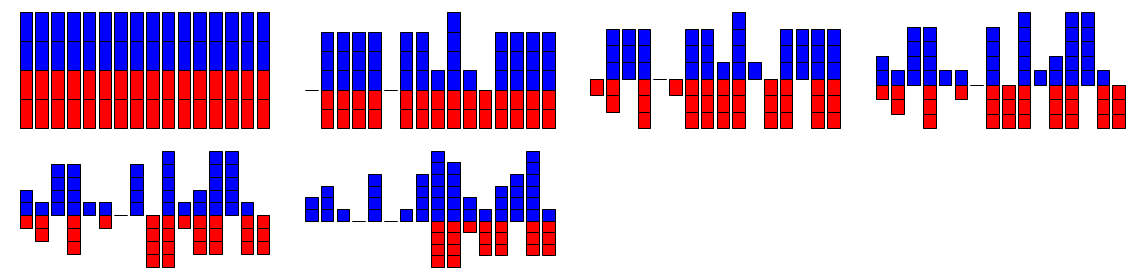

In [55]:
draw_boards(positions)

In [56]:
moves

[10, 2, 1, 7, 9]

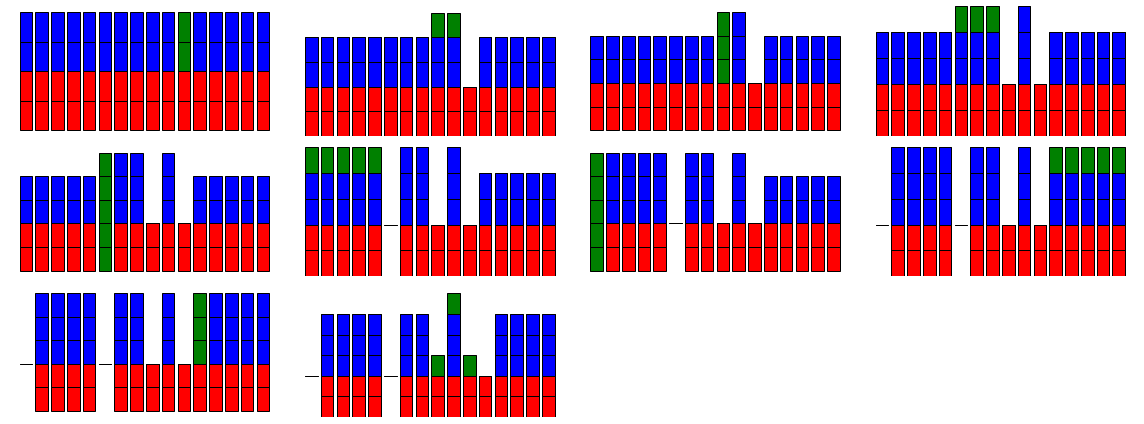

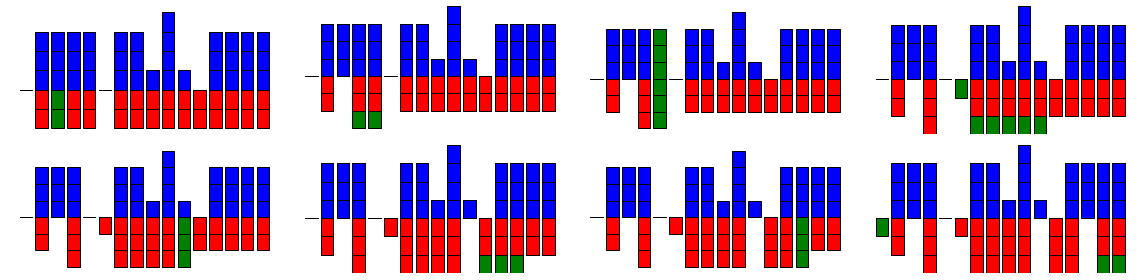

In [61]:
#Visualize only the first two moves by using the moves-array
player = 0
board = np.full((2,16),2)
visualize_game(board, moves[:2], player)

### Play one game with a simple optimization

From all legal moves, only those with maximum number of stones win are kept.

In [62]:
def find_best_moves(player, board, legal_moves):
    '''return all moves with max. number of stones'''
    moves = []
    for field in legal_moves:
        test_board = board.copy()
        test_board = full_turn(player,field, test_board)
        moves.append(test_board[player].sum())
    moves = np.array(moves)
    best = moves.max()
    indices = np.where(moves == best)
    best_moves = [legal_moves[i] for i in indices[0]]
    return best_moves

In [64]:
#example
board = np.full((2,16),2)
legal_moves = find_legal_moves(0,board)
idx = find_best_moves(0,board, legal_moves)
idx

[2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [65]:
def play_game_optimized(player = 0, board = np.full((2,16),2)): 
    '''plays a game and uses the maximized stone result (see above)
    if more than one moves are possible, the move is choosen randomly'''
    game_positions = [] #collects the positions
    game_fields = [] #collects the start field of the game
    game_positions.append(board.copy()) #save the first position
    count = 0 #collects the number of moves in one turn
    chance = 0 #collects the number of moves in one turn that are choosen randomly from the possible moves
    legal_moves = find_legal_moves(player, board)
    while len(legal_moves) > 0:
        best_moves =find_best_moves(player, board, legal_moves)
        field = random.choice(best_moves)
        if len(best_moves) > 1: chance += 1
        game_fields.append(field) #save the start field
        board = full_turn(player, field, board)
        game_positions.append(board.copy()) #saves the new positions
        player = (player + 1)%2 #selects the other player
        legal_moves = find_legal_moves(player, board)
        count += 1
    if count == 0: randomness = 0
    else: randomness = chance/count
    return game_positions, game_fields, randomness

In [66]:
positions, moves, randomness = play_game_optimized()
print(f"The game lasted {len(positions)} turns and was to {randomness*100:.2f}% guided by random choices.")

The game lasted 49 turns and was to 31.25% guided by random choices.


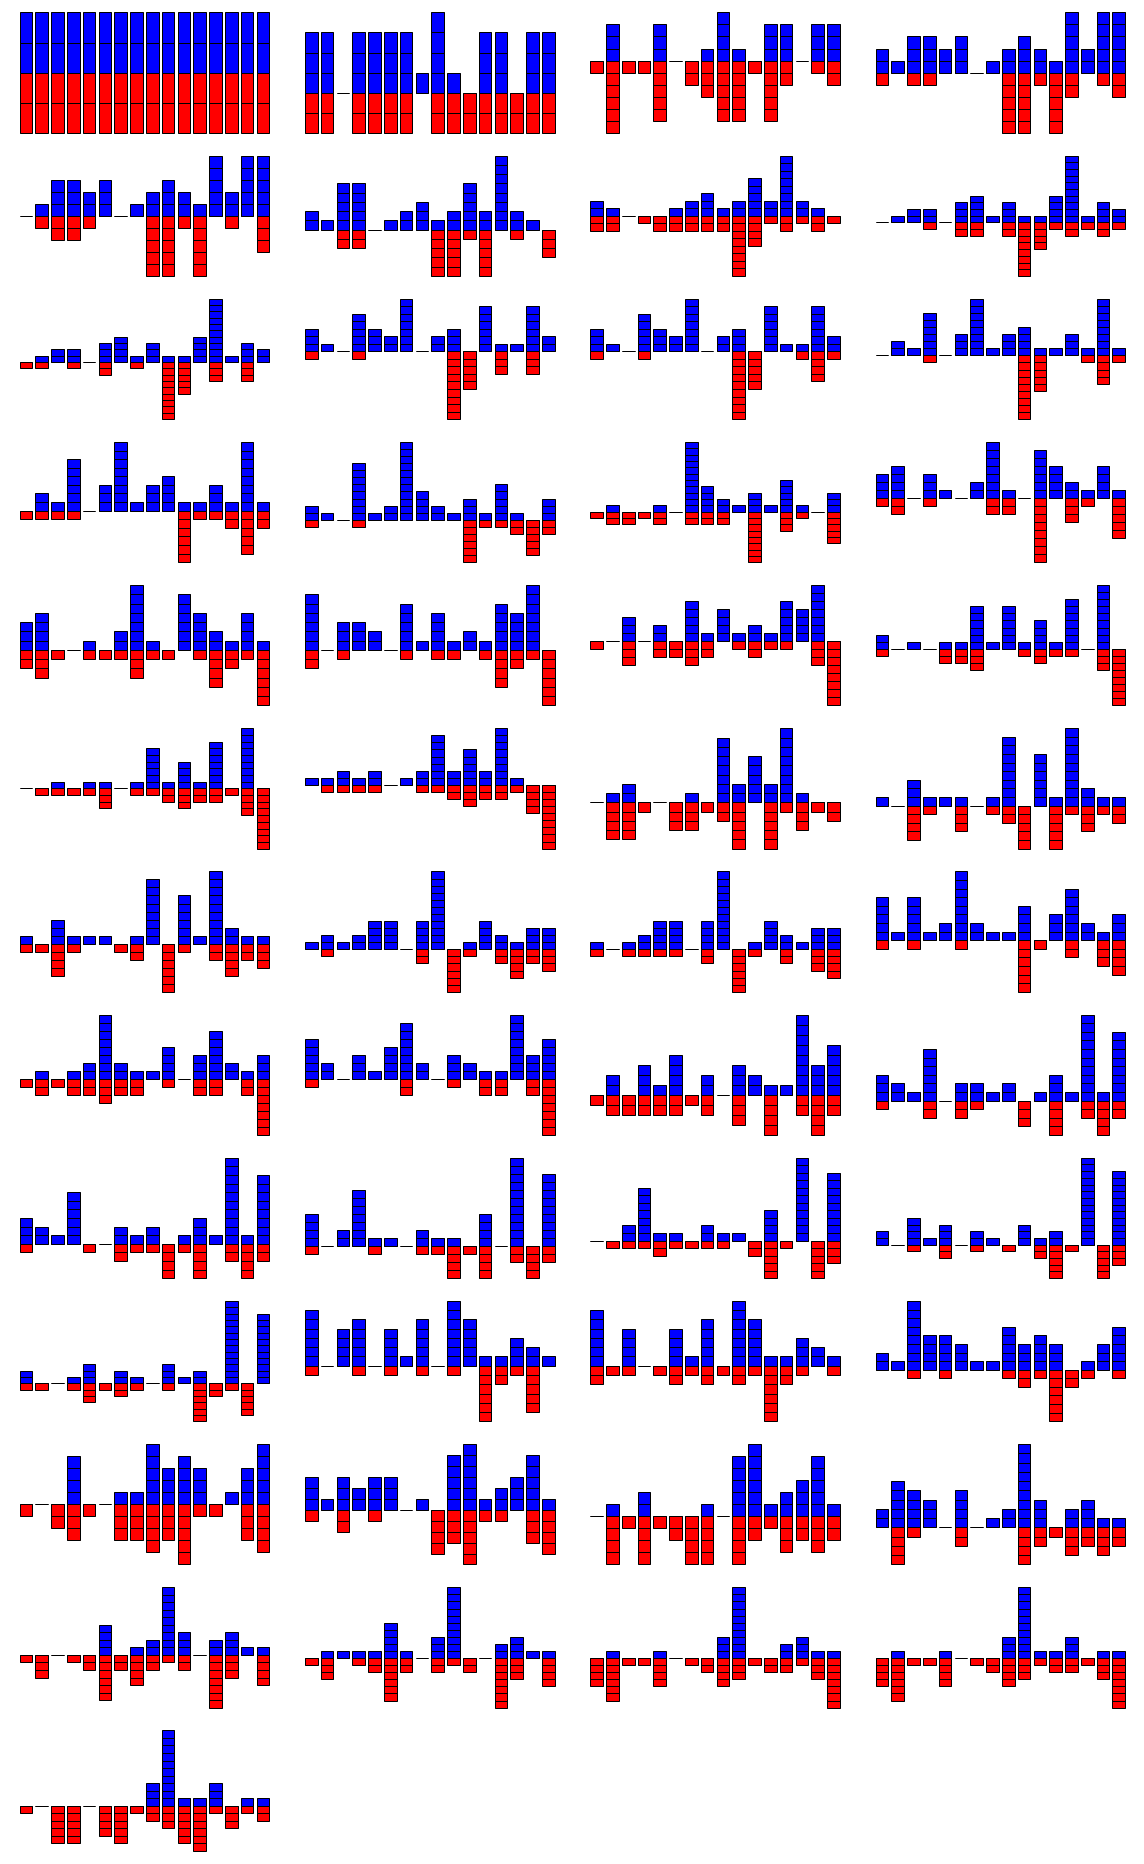

In [67]:
draw_boards(positions)

In [68]:
moves

[9,
 14,
 8,
 12,
 13,
 8,
 9,
 6,
 8,
 12,
 15,
 9,
 8,
 14,
 15,
 8,
 10,
 12,
 4,
 4,
 14,
 15,
 11,
 5,
 12,
 13,
 7,
 12,
 15,
 15,
 5,
 3,
 8,
 9,
 11,
 15,
 15,
 14,
 10,
 9,
 8,
 9,
 13,
 15,
 10,
 12,
 13,
 14]

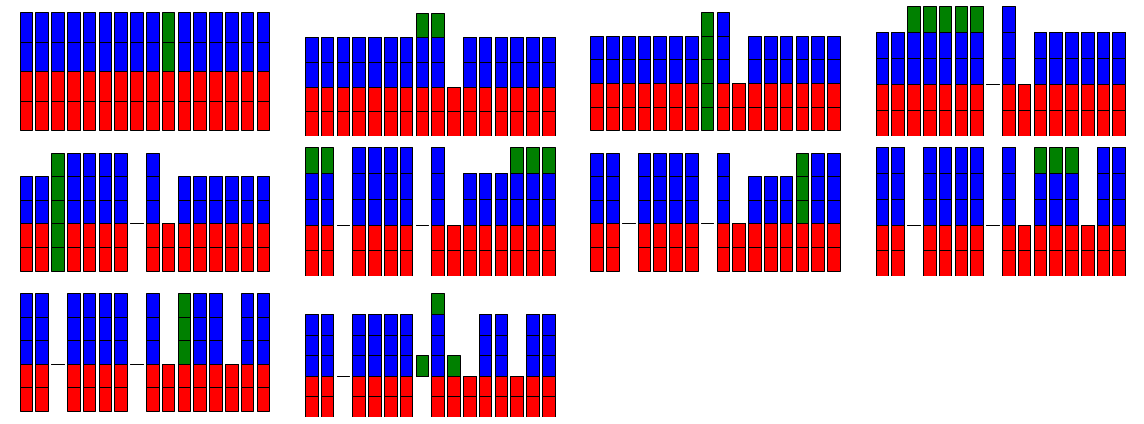

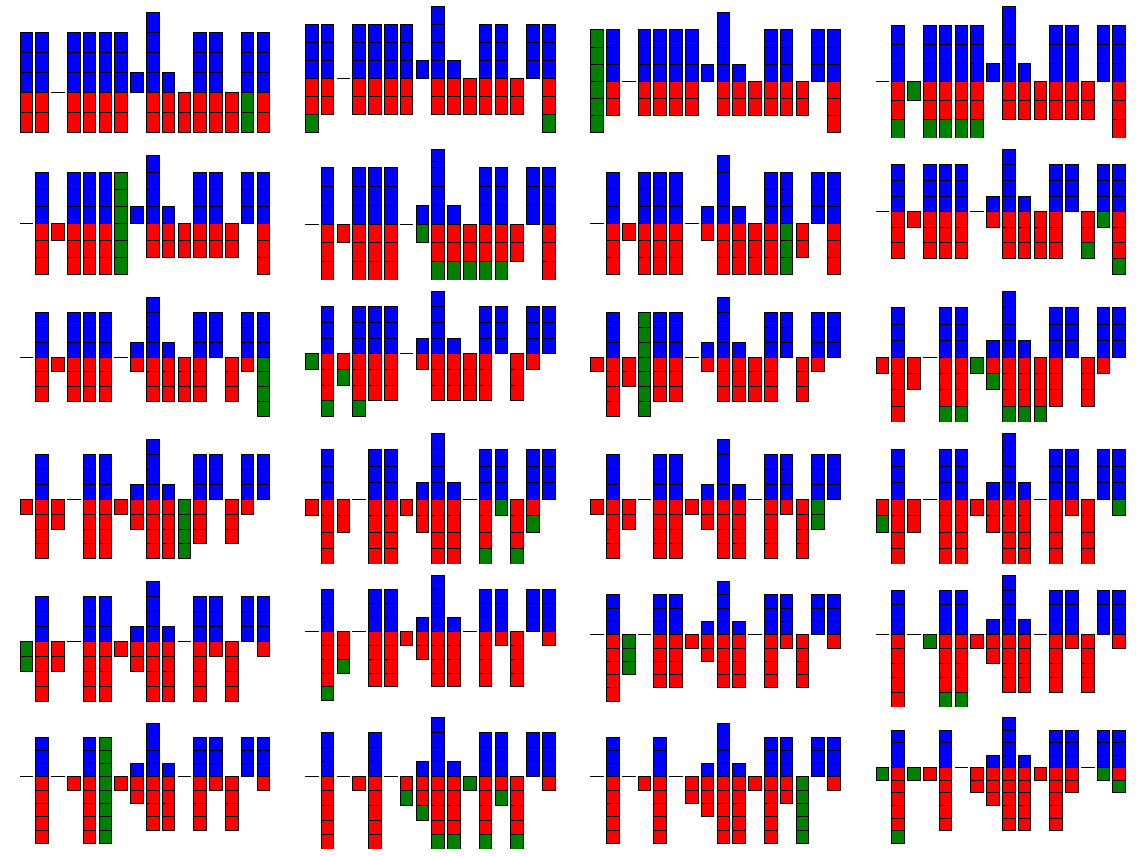

In [69]:
visualize_game(board, moves[:2], player)

### Playing n games

Needed for getting statistics

In [14]:
def generate_games(n, game_func):
    games_pos = np.empty(n, dtype=object)
    games_moves = []
    games_randomness = []
    for i in range(n):
        positions, moves, randomness = game_func()
        games_pos[i] = np.array(positions)
        games_moves.append(moves)
        games_randomness.append(randomness)
    return games_pos, games_moves,games_randomness


In [37]:
n = 10
games_pos, games_moves, games_randomness =generate_games(n, play_game_optimized)

10

### Evaluating

In [15]:
n_games = [10,100,1000,10000]

pos_r = []
moves_r = []
rand_r = []
pos_o = []
moves_o = []
rand_o = []
for n in n_games:
    print(f"For n = {n}")
    start_time = time.time()
    print("Completely random")
    games_pos_r, games_moves_r, games_randomness_r = generate_games(n, play_game_random)
    end_time = time.time()
    exec_time = end_time-start_time
    print(f"Time: {exec_time:.2f}")
    pos_r.append(games_pos_r)
    moves_r.append(games_moves_r)
    rand_r.append(games_randomness_r)

    start_time = time.time()
    print("First move optimized")
    games_pos_o, games_moves_o, games_randomness_o = generate_games(n, play_game_optimized)
    end_time = time.time()
    print(f"Time: {end_time-start_time:.2f}")
    pos_o.append(games_pos_o)
    moves_o.append(games_moves_o)
    rand_o.append(games_randomness_o)



For n = 10
Completely random
Time: 0.04
First move optimized
Time: 0.12
For n = 100
Completely random
Time: 0.40
First move optimized
Time: 1.10
For n = 1000
Completely random
Time: 4.02
First move optimized
Time: 10.76
For n = 10000
Completely random
Time: 39.77
First move optimized
Time: 104.46


In [15]:
def measure(games_moves, games_randomness):
    collect_len = []
    for i in range(len(games_moves)):
        collect_len.append(len(games_moves[i]))
    collect_len = np.array(collect_len)
    print(f"mean {collect_len.mean():.2f}, std: {collect_len.std():.2f}")
    print(f"min {collect_len.min()}, max: {collect_len.max()}")
    print(f"Proportion of moves with random choice: {np.array(games_randomness).mean():.2f}, std: {np.array(games_randomness).std():.2f}")
    return collect_len    

In [17]:
collect_len_r = []
collect_len_o = []
for i in range(len(n_games)):
    collect_len_r.append(measure(moves_r[i], rand_r[i]))
    collect_len_o.append(measure(moves_o[i], rand_o[i]))

mean 49.70, std: 31.39
min 7, max: 93
Proportion of moves with random choice: 0.99, std: 0.01
mean 19.00, std: 12.48
min 9, max: 50
Proportion of moves with random choice: 0.42, std: 0.13
mean 58.34, std: 40.54
min 8, max: 191
Proportion of moves with random choice: 0.99, std: 0.02
mean 16.93, std: 10.89
min 4, max: 58
Proportion of moves with random choice: 0.44, std: 0.13
mean 54.93, std: 44.03
min 3, max: 303
Proportion of moves with random choice: 0.99, std: 0.03
mean 16.43, std: 10.10
min 4, max: 88
Proportion of moves with random choice: 0.45, std: 0.12
mean 54.94, std: 43.64
min 3, max: 359
Proportion of moves with random choice: 0.99, std: 0.03
mean 16.23, std: 9.52
min 4, max: 87
Proportion of moves with random choice: 0.44, std: 0.12


The values stabilize.

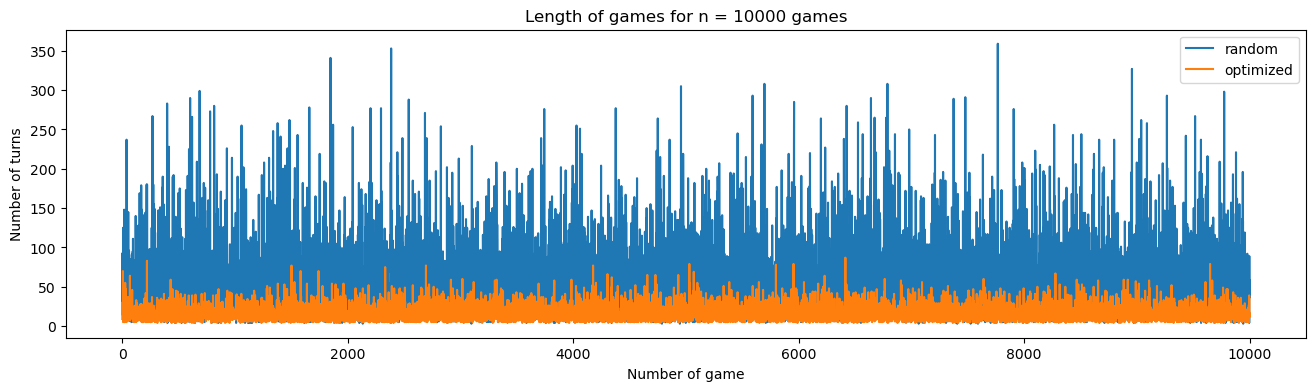

In [33]:
plt.figure(figsize=(16,4))
plt.title("Length of games for n = 10000 games")
plt.plot(collect_len_r[3], label="random")
plt.plot(collect_len_o[3], label="optimized")
plt.xlabel("Number of game")
plt.ylabel("Number of turns")
plt.legend()
plt.show()

In [19]:
x = [1,2,3,4]
mean_values_r = [np.mean(lst) for lst in collect_len_r]
mean_values_o = [np.mean(lst) for lst in collect_len_o]
std_val_r = [np.std(lst) for lst in collect_len_r]
std_val_o = [np.std(lst) for lst in collect_len_o]

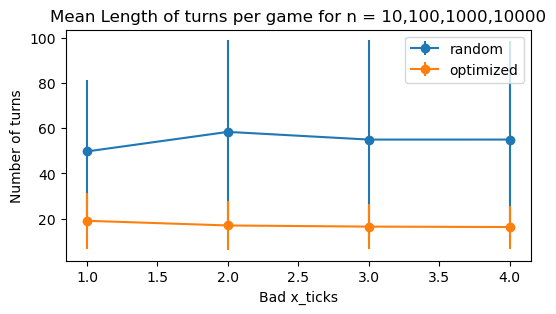

In [34]:
plt.figure(figsize=(6,3))
plt.title("Mean Length of turns per game for n = 10,100,1000,10000")
plt.errorbar(x, mean_values_r, marker = 'o', yerr = std_val_r, label = "random")
plt.errorbar(x, mean_values_o, marker = 'o', yerr = std_val_o, label = "optimized")
#Randomness is constant 1 and 0.5
plt.xlabel("Bad x_ticks")
plt.ylabel("Number of turns")
plt.legend()
plt.show()

In [16]:
def give_ratio(games_positions):
    positions = []
    for game in games_positions:
        for position in game:
            positions.append(position)
    positions = np.array(positions)
    unique_pos = np.array([x.reshape(-1) for x in positions])
    unique_pos = np.unique(unique_pos, axis = 0)
    unique_pos = np.array([x.reshape(2,16) for x in unique_pos])
    print(f"{len(unique_pos)}/{len(positions)}")
    print (f"Ratio Unique/All: {len(unique_pos)/len(positions)}")
    return unique_pos, len(unique_pos)/len(positions)


In [28]:
unique_pos_r = []
unique_pos_o = []
ratio_r = []
ratio_o = []
for i in range(len(n_games)):
    ur, rr = give_ratio(pos_r[i])
    uo, ro = give_ratio(pos_o[i])
    unique_pos_r.append(ur)
    unique_pos_o.append(uo)
    ratio_r.append(rr)
    ratio_o.append(ro)

495/507
Ratio Unique/All: 0.9763313609467456
187/200
Ratio Unique/All: 0.935
5729/5934
Ratio Unique/All: 0.965453319851702
1073/1793
Ratio Unique/All: 0.5984383714445064
52941/55932
Ratio Unique/All: 0.94652435099764
6921/17425
Ratio Unique/All: 0.39718794835007176
519275/559387
Ratio Unique/All: 0.9282929349448593
37837/172337
Ratio Unique/All: 0.21955238863389753


The proportion of unique vs. all board positions in the optimized variant keeps getting better. With 100000 games it will be around 13%.

In [29]:
n_unique_r = [len(lst) for lst in unique_pos_r]
n_unique_o = [len(lst) for lst in unique_pos_o]

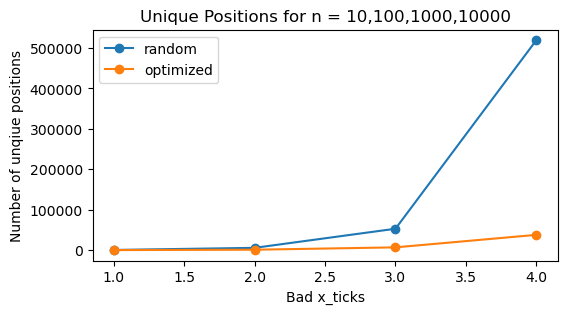

In [36]:
plt.figure(figsize=(6,3))
plt.title("Unique Positions for n = 10,100,1000,10000")
plt.plot(x, n_unique_r, marker = 'o', label = "random")
plt.plot(x, n_unique_o, marker = 'o', label = "optimized")
plt.xlabel("Bad x_ticks")
plt.ylabel("Number of unqiue positions")
plt.legend()
plt.show()

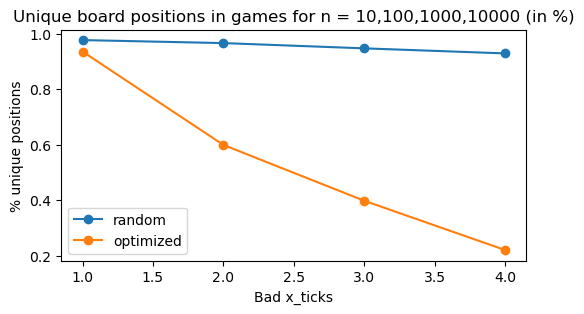

In [37]:
plt.figure(figsize=(6,3))
plt.title("Unique board positions in games for n = 10,100,1000,10000 (in %)")
plt.plot(x, ratio_r, marker = 'o', label = "random")
plt.plot(x, ratio_o, marker = 'o', label = "optimized")
plt.xlabel("Bad x_ticks")
plt.ylabel("% unique positions")
plt.legend()
plt.show()

In [17]:
def check_for_loops(positions):
    for i in range(len(positions)):
        count = 0
        for j in range(len(positions[i])):
            if  positions[i][j][-1][0][:8].sum() > 0 and positions[i][j][-1][1][:8].sum() > 0:
                #print(i,j)
                count += 1
        print(f"In series {i} there are {count} loops")
        if count > 0:
            print(f"{count/len(positions[i]):.2f}%")

In [84]:
check_for_loops(pos_r)

In series 0 there are 0 loops
In series 1 there are 14 loops
0.14%
In series 2 there are 186 loops
0.19%
In series 3 there are 1899 loops
0.19%


In [85]:
check_for_loops(pos_o)

In series 0 there are 0 loops
In series 1 there are 0 loops
In series 2 there are 8 loops
0.01%
In series 3 there are 69 loops
0.01%


There is a small risk for external loops (at least with the current implementation of the game). It it smaller for the optimized variant

### Creating database of unique positions

I created 100000 games with the optimized variant. Then I extracted the unique positions and made labels that annotate how often the positions occured in winning/loosing/looping games (that took the machine 5 hours).


In [2]:
labels = np.load("labels.npy")
unique = np.load("unique.npy")

In [3]:
print(f"{len(unique)} individual positions.")

217890 individual positions.


In [4]:
#First number: Number of games the position was included and player 0 won
#Second number: Number of games the position was included and player 0 lost
#Third number: Number of games the position was included and game ended in an eternal loop
print(labels[0])

[1. 0. 0.]


In [5]:
#Summing over all labels gives the number of games a position was included
sums = np.sum(labels, axis = 1)
#finding the position that was included in the most games
idx = np.where(sums == sums.max())
idx = idx[0][0]
#it is the start position...
unique[idx]
print(f"Starting position led to a win in {labels[idx][0]/100000:.2f} % cases, to loss in {labels[idx][1]/100000:.2f} % cases and to a loop in {labels[idx][2]/100000:.2f}% cases.")

Starting position led to a win in 0.51 % cases, to loss in 0.48 % cases and to a loop in 0.01% cases.


In [6]:
#Dropping the start position
labels = np.delete(labels, idx, axis = 0)
unique = np.delete(unique, idx, axis = 0)
sums = np.delete(sums, idx, axis = 0)

In [7]:
#How many positions appear in 10 or less games
indices = np.where(sums <= 10)
print(f"{len(indices[0])}, that is {len(indices[0])/len(unique)*100:.2f} % of the unique positions.")

208141, that is 95.53 % of the unique positions.


In [8]:
#How many positions appear in 11 or more games
indices = np.where(sums > 10)
print(f"{len(indices[0])}, that is {len(indices[0])/len(unique)*100:.2f} % of the unique positions.")

9748, that is 4.47 % of the unique positions.


In [9]:
indices = np.array(indices[0])
indices.shape

(9748,)

In [228]:
#Very few positions turn up more often, but at most about in 8% of the games. Most positions are extremly rare.
#Labelling single positions isn't that useful? Categories are needed? Or criteria?
